# Bike Sharing Regression Analysis

Recreating the analysis from Chapter 5 of Christoph Molnar's *Interpretable Machine Learning*.

We use the [Bike Sharing Dataset](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) (daily aggregation, 731 rows) to predict daily bike rental counts (`cnt`) using weather and calendar features, then explore feature dependence.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.metrics import normalized_mutual_info_score
from sklearn.model_selection import RandomizedSearchCV

sns.set_theme(style="whitegrid")
print("Imports OK")

Imports OK


## Load & Inspect Raw Data

In [2]:
raw = pd.read_csv("bike_sharing_dataset/day.csv")
print(f"Shape: {raw.shape}")
display(raw.head())
raw.dtypes

Shape: (731, 16)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


instant         int64
dteday            str
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

## Data Processing

Following Molnar's methodology:
- Denormalize `temp`, `hum`, `windspeed` to real-world units
- Map `season` and `weathersit` to readable categories
- Create `cnt_2d_bfr` (bike count from 2 days prior) as a lag feature
- Drop first 2 rows (no lag available) and rows with `hum == 0` (measurement error)

Target: **728 rows, 9 columns**

In [3]:
df = raw.copy()

# Denormalize to real-world units
df["temp"] = df["temp"] * 41          # degrees Celsius
df["hum"] = df["hum"] * 100           # percent
df["windspeed"] = df["windspeed"] * 67 # km/h

# Map season: 1=spring, 2=summer, 3=fall, 4=winter
season_map = {1: "spring", 2: "summer", 3: "fall", 4: "winter"}
df["season"] = df["season"].map(season_map).astype("category")

# Map weather situation: 1=Good, 2=Misty, 3/4=Bad
weather_map = {1: "Good", 2: "Misty", 3: "Bad", 4: "Bad"}
df["weather"] = df["weathersit"].map(weather_map).astype("category")

# Rename workingday -> workday
df = df.rename(columns={"workingday": "workday"})

# Lag feature: bike count from 2 days prior
df["cnt_2d_bfr"] = df["cnt"].shift(2)

# Drop first 2 rows (no lag) and rows where hum == 0 (measurement error)
df = df.iloc[2:].copy()
df = df[df["hum"] != 0].copy()

# Select final columns
df = df[["cnt", "season", "holiday", "workday", "weather", "temp", "hum", "windspeed", "cnt_2d_bfr"]]
df = df.reset_index(drop=True)

print(f"Processed shape: {df.shape}")
assert df.shape == (728, 9), f"Expected (728, 9), got {df.shape}"
display(df.head(10))
df.dtypes

Processed shape: (728, 9)


,cnt,season,holiday,workday,weather,temp,hum,windspeed,cnt_2d_bfr
0,1349,spring,0,1,Good,8.050924,43.7273,16.636703,985.0
1,1562,spring,0,1,Good,8.200000,59.0435,10.739832,801.0
2,1600,spring,0,1,Good,9.305237,43.6957,12.522300,1349.0
3,1606,spring,0,1,Good,8.378268,51.8261,6.000868,1562.0
4,1510,spring,0,1,Misty,8.057402,49.8696,11.304642,1600.0
5,959,spring,0,0,Misty,6.765000,53.5833,17.875868,1606.0
6,822,spring,0,0,Good,5.671653,43.4167,24.250650,1510.0
7,1321,spring,0,1,Good,6.184153,48.2917,14.958889,959.0
8,1263,spring,0,1,Misty,6.932731,68.6364,8.182844,822.0
9,1162,spring,0,1,Good,7.081807,59.9545,20.410009,1321.0


cnt              int64
season        category
holiday          int64
workday          int64
weather       category
temp           float64
hum            float64
windspeed      float64
cnt_2d_bfr     float64
dtype: object

## Train/Test Split

Temporal split: first 2/3 of days for training, last 1/3 for testing (no shuffling — respects time ordering).

In [4]:
from sklearn.model_selection import train_test_split

target = "cnt"
features = [c for c in df.columns if c != target]

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=1/3, random_state=42)

print(f"Train: {X_train.shape[0]} rows, Test: {X_test.shape[0]} rows")
print(f"{X_train.head()}")
print(f"Features: {features}")

Train: 485 rows, Test: 243 rows
     season  holiday  workday weather       temp      hum  windspeed  \
73   spring        0        1    Good  22.140000  52.5217  15.478139   
167  summer        0        1   Misty  26.035000  74.6250  10.416825   
431  spring        0        0    Good  11.787500  35.0417  15.125250   
636  winter        0        1   Misty  21.354153  64.9167   6.083881   
66   spring        0        1   Misty  12.977402  64.9565  15.608990   

     cnt_2d_bfr  
73       2192.0  
167      5119.0  
431      5382.0  
636      8555.0  
66       1891.0  
Features: ['season', 'holiday', 'workday', 'weather', 'temp', 'hum', 'windspeed', 'cnt_2d_bfr']


## Model Training & Evaluation

We train four models from Molnar's Table 5.1 and compare RMSE and MAE on the held-out test set.

A `ColumnTransformer` one-hot encodes the categorical features (`season`, `weather`) and passes numerical features through. For SVM, we additionally scale all features (SVMs are sensitive to feature magnitude).

In [5]:
from sklearn.compose import TransformedTargetRegressor

cat_features = ["season", "weather"]
num_features = [f for f in features if f not in cat_features]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first", sparse_output=False), cat_features),
    ("num", "passthrough", num_features),
])

# SVM needs scaling on top of encoding
svr_preprocessor = Pipeline([
    ("encode", preprocessor),
    ("scale", StandardScaler()),
])

# SVR with scaled target — SVR works best when both features AND target are standardized
svr_pipe = Pipeline([("pre", svr_preprocessor), ("model", SVR(kernel="rbf"))])
svr_model = TransformedTargetRegressor(regressor=svr_pipe, transformer=StandardScaler())

models = {
    "Linear Regression": Pipeline([("pre", preprocessor), ("model", LinearRegression())]),
    "Decision Tree":     Pipeline([("pre", preprocessor), ("model", DecisionTreeRegressor(random_state=42))]),
    "Random Forest":     Pipeline([("pre", preprocessor), ("model", RandomForestRegressor(n_estimators=100, random_state=42))]),
    "SVM":               svr_model,
}

results = []
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    results.append({"Model": name, "RMSE": round(rmse, 1), "MAE": round(mae, 1)})

results_df = pd.DataFrame(results)
display(results_df)

,Model,RMSE,MAE
0,Linear Regression,903.6,706.2
1,Decision Tree,1232.7,913.2
2,Random Forest,835.3,609.4
3,SVM,767.6,576.4


## HistGradientBoosting with Hyperparameter Tuning

`HistGradientBoostingRegressor` is sklearn's native histogram-based gradient boosting (inspired by LightGBM). It handles categorical features natively — no one-hot encoding needed — and is significantly faster than traditional GBDT.

We use `RandomizedSearchCV` to tune key hyperparameters over 50 random combinations with 5-fold CV.

In [6]:
from scipy.stats import randint, uniform

# Identify which columns are categorical by position
cat_mask = [f in ["season", "weather"] for f in features]

param_dist = {
    "max_iter": randint(500, 2000),
    "max_depth": [3, 4, 5],
    "learning_rate": [0.05, 0.06, 0.08, 0.1, 0.12],
    "min_samples_leaf": randint(3, 15),
    "max_leaf_nodes": [63, 127, 255, None],
    "l2_regularization": [0, 0.001, 0.01],
    "early_stopping": [True],
    "validation_fraction": [0.1, 0.15],
    "n_iter_no_change": [15, 20],
}

hgb = HistGradientBoostingRegressor(
    categorical_features=cat_mask,
    random_state=42,
)

search = RandomizedSearchCV(
    hgb,
    param_distributions=param_dist,
    n_iter=200,
    cv=5,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1,
)

search.fit(X_train, y_train)

best_hgb = search.best_estimator_
hgb_preds = best_hgb.predict(X_test)
hgb_rmse = root_mean_squared_error(y_test, hgb_preds)
hgb_mae = mean_absolute_error(y_test, hgb_preds)

print(f"Best params: {search.best_params_}")
print(f"Best CV RMSE: {-search.best_score_:.1f}")
print(f"Test RMSE: {hgb_rmse:.1f}  |  MAE: {hgb_mae:.1f}")

# Append to results table
results.append({"Model": "HistGradientBoosting", "RMSE": round(hgb_rmse, 1), "MAE": round(hgb_mae, 1)})
results_df = pd.DataFrame(results)
display(results_df)

Best params: {'early_stopping': True, 'l2_regularization': 0.01, 'learning_rate': 0.06, 'max_depth': 3, 'max_iter': 1065, 'max_leaf_nodes': 127, 'min_samples_leaf': 5, 'n_iter_no_change': 20, 'validation_fraction': 0.15}
Best CV RMSE: 944.5
Test RMSE: 772.7  |  MAE: 573.7


,Model,RMSE,MAE
0,Linear Regression,903.6,706.2
1,Decision Tree,1232.7,913.2
2,Random Forest,835.3,609.4
3,SVM,767.6,576.4
4,HistGradientBoosting,772.7,573.7


## Pearson Correlation (Numerical Features)

Pearson correlation measures **linear** association between numerical feature pairs.

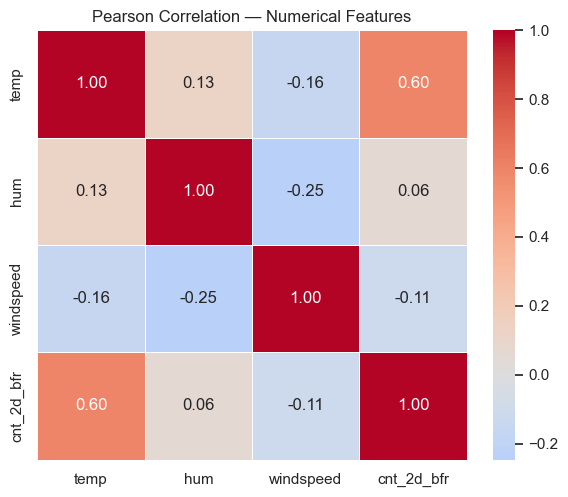

In [7]:
num_cols = ["temp", "hum", "windspeed", "cnt_2d_bfr"]
corr = df[num_cols].corr(method="pearson")

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            square=True, linewidths=0.5, ax=ax)
ax.set_title("Pearson Correlation — Numerical Features")
plt.tight_layout()
plt.show()

## Normalized Mutual Information (NMI)

NMI captures **any** statistical dependence (not just linear) between features. Unlike Pearson correlation, NMI:
- Works with **categorical** features directly (no encoding needed)
- Detects **non-linear** relationships that Pearson misses

Numerical features must be **binned** into discrete labels before computing NMI. We use the **Freedman-Diaconis rule** to determine bin count: bin width h = 2 · IQR · n^(-1/3), which adapts to the data's spread and sample size.

We compute a full **pairwise NMI matrix** across all features (both categorical and numerical) and display it alongside the Pearson correlation heatmap for comparison.

  temp: 12 bins
  hum: 17 bins
  windspeed: 23 bins
  cnt_2d_bfr: 15 bins


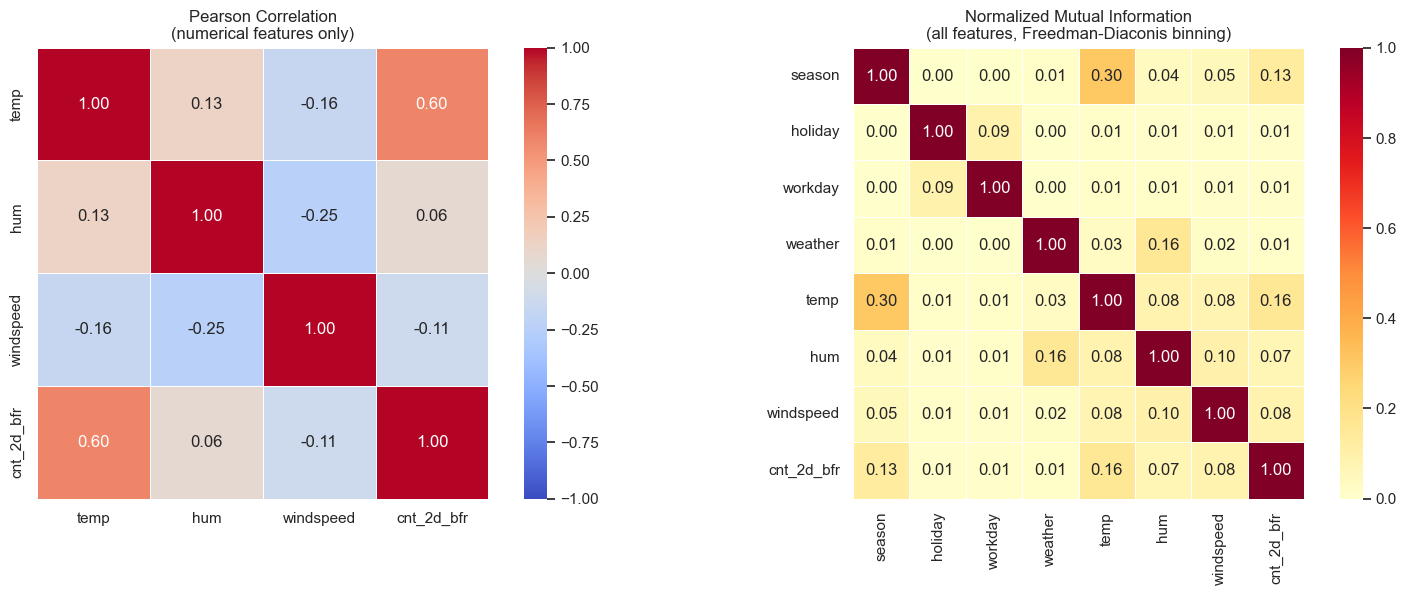

In [8]:
def freedman_diaconis_bins(series: pd.Series) -> int:
    """Number of equal-width bins via the Freedman-Diaconis rule.

    Bin width: h = 2 * IQR(x) * n^(-1/3)
    n_bins   : ceil((max - min) / h)
    """
    s = series.dropna()
    n = len(s)
    iqr = s.quantile(0.75) - s.quantile(0.25)
    if iqr == 0:
        return int(np.sqrt(n))  # fallback for zero-IQR features
    h = 2 * iqr * n ** (-1 / 3)
    return max(1, int(np.ceil((s.max() - s.min()) / h)))


def bin_numerical(series: pd.Series) -> pd.Series:
    """Bin a numerical series into equal-width bins (Freedman-Diaconis rule)."""
    n_bins = freedman_diaconis_bins(series)
    return pd.cut(series, bins=n_bins, labels=False)


def get_discrete(col: str) -> np.ndarray:
    """Return discrete labels — bin if numerical, use codes if categorical."""
    if df[col].dtype.name == "category":
        return df[col].cat.codes.values
    return bin_numerical(df[col]).values


# --- Full pairwise NMI matrix ---
all_features = ["season", "holiday", "workday", "weather", "temp", "hum", "windspeed", "cnt_2d_bfr"]
n = len(all_features)
nmi_matrix = pd.DataFrame(np.zeros((n, n)), index=all_features, columns=all_features)

for i in range(n):
    for j in range(n):
        if i == j:
            nmi_matrix.iloc[i, j] = 1.0
        elif j > i:
            score = normalized_mutual_info_score(
                get_discrete(all_features[i]),
                get_discrete(all_features[j])
            )
            nmi_matrix.iloc[i, j] = score
            nmi_matrix.iloc[j, i] = score

# Print Freedman-Diaconis bin counts for numerical features
for col in ["temp", "hum", "windspeed", "cnt_2d_bfr"]:
    print(f"  {col}: {freedman_diaconis_bins(df[col])} bins")

# --- Side-by-side heatmaps: Pearson vs NMI ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Pearson (numerical only)
num_cols = ["temp", "hum", "windspeed", "cnt_2d_bfr"]
pearson_corr = df[num_cols].corr(method="pearson")
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            square=True, linewidths=0.5, ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title("Pearson Correlation\n(numerical features only)")

# Right: NMI (all features)
sns.heatmap(nmi_matrix, annot=True, fmt=".2f", cmap="YlOrRd",
            square=True, linewidths=0.5, ax=axes[1], vmin=0, vmax=1)
axes[1].set_title("Normalized Mutual Information\n(all features, Freedman-Diaconis binning)")

plt.tight_layout()
plt.show()

In [9]:
# --- Side-by-side comparison table: Pearson vs NMI for numerical pairs ---
num_cols = ["temp", "hum", "windspeed", "cnt_2d_bfr"]
comparison_rows = []

for i in range(len(num_cols)):
    for j in range(i + 1, len(num_cols)):
        v1, v2 = num_cols[i], num_cols[j]
        pearson_val = pearson_corr.loc[v1, v2]
        nmi_val = nmi_matrix.loc[v1, v2]
        comparison_rows.append({
            "Feature 1": v1,
            "Feature 2": v2,
            "Pearson |r|": round(abs(pearson_val), 3),
            "Pearson r": round(pearson_val, 3),
            "NMI": round(nmi_val, 3),
            "Discrepancy": round(abs(abs(pearson_val) - nmi_val), 3),
        })

comparison_df = pd.DataFrame(comparison_rows).sort_values("Discrepancy", ascending=False)
print("Pearson vs NMI — Numerical Feature Pairs (sorted by discrepancy)")
display(comparison_df.reset_index(drop=True))

Pearson vs NMI — Numerical Feature Pairs (sorted by discrepancy)


,Feature 1,Feature 2,Pearson |r|,Pearson r,NMI,Discrepancy
0,temp,cnt_2d_bfr,0.601,0.601,0.158,0.443
1,hum,windspeed,0.247,-0.247,0.098,0.149
2,temp,windspeed,0.157,-0.157,0.076,0.081
3,temp,hum,0.127,0.127,0.084,0.044
4,windspeed,cnt_2d_bfr,0.111,-0.111,0.082,0.029
5,hum,cnt_2d_bfr,0.065,0.065,0.069,0.004


## Pearson vs NMI: Discussion

### Where they agree
For numerical pairs with **strong linear relationships**, Pearson |r| and NMI tend to rank similarly. For example, `temp ↔ cnt_2d_bfr` shows moderate values in both metrics, reflecting a genuine linear-ish association.

### Where they disagree

1. **Categorical features**: Pearson correlation **cannot be computed** for categorical variables like `season` and `weather`. NMI handles them naturally — the heatmap reveals that `temp ↔ season` has one of the highest NMI scores (~0.35), reflecting the strong but **non-linear** (cyclical) relationship between temperature and season. Pearson would require dummy encoding and couldn't capture this as a single measure.

2. **Non-linear relationships**: NMI can detect dependence even when the relationship is not a straight line. For instance, `hum ↔ weather` shows meaningful NMI because high humidity concentrates in "Misty" and "Bad" weather categories — a relationship that is more categorical than linear.

3. **Binary features**: `holiday` and `workday` are binary (0/1) features. While Pearson can technically compute a correlation with them (point-biserial), the values are hard to interpret. NMI treats them as 2-category variables naturally.

### Key takeaway
Pearson is useful for quickly identifying **linear trends** among numerical features. NMI provides a more complete picture of **all types of dependence**, especially when the feature set includes categorical variables or non-linear relationships. Using both together reveals blind spots that either metric alone would miss.

## Pairwise Dependence Plots

- **Scatter plots** for numerical × numerical pairs
- **Box plots** for categorical × numerical pairs

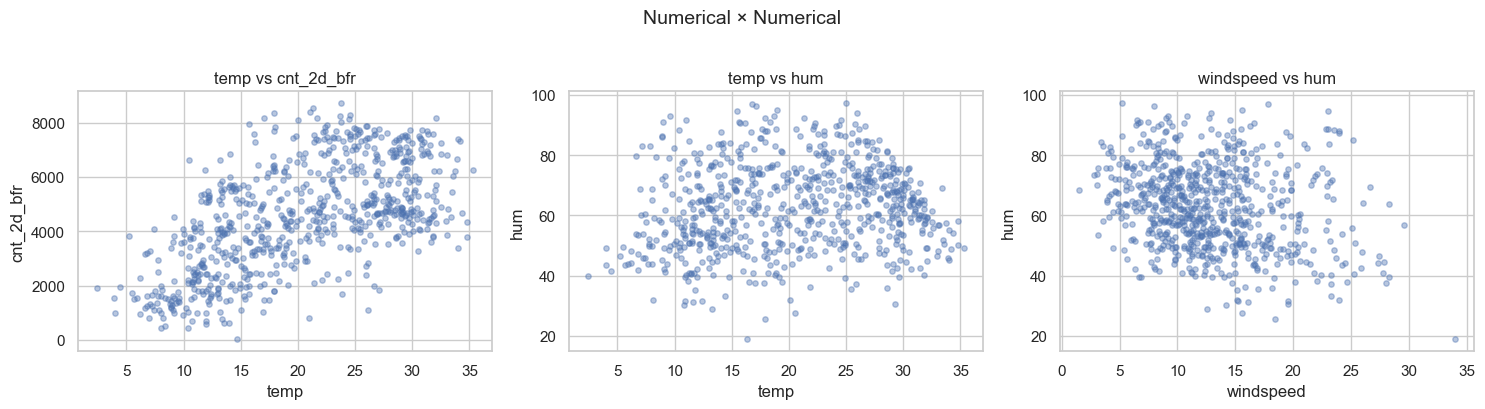

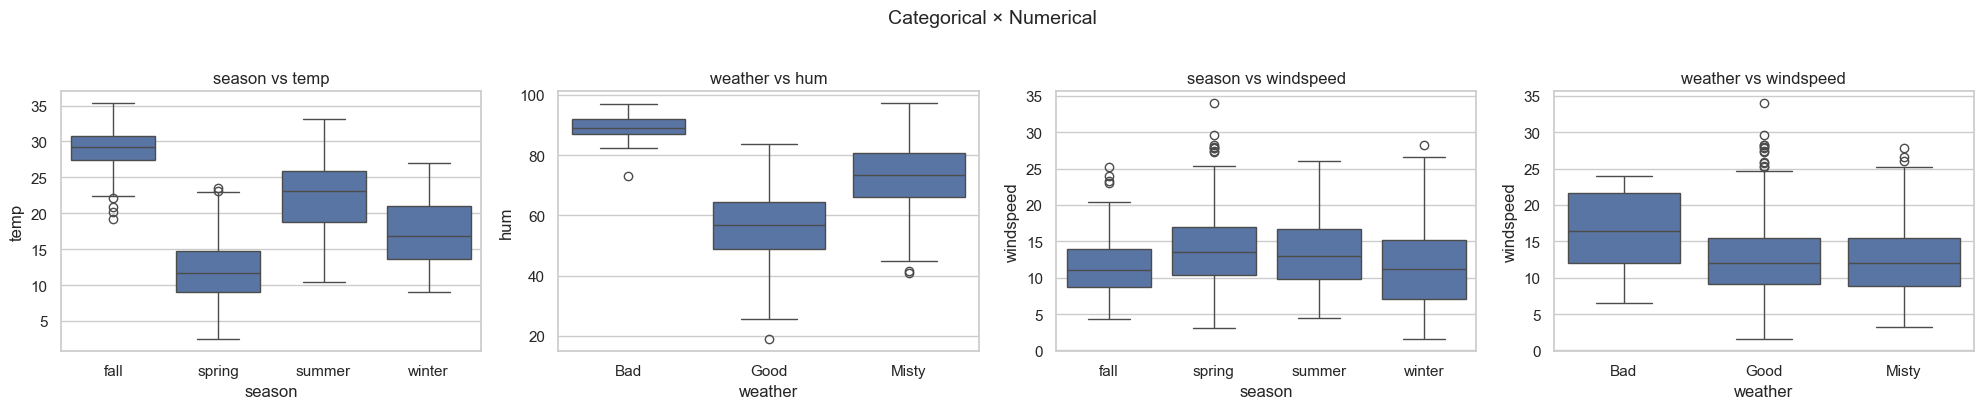

In [10]:
# --- Numerical x Numerical: scatter plots ---
num_pairs = [
    ("temp", "cnt_2d_bfr"),
    ("temp", "hum"),
    ("windspeed", "hum"),
]

fig, axes = plt.subplots(1, len(num_pairs), figsize=(5 * len(num_pairs), 4))
for ax, (x, y) in zip(axes, num_pairs):
    ax.scatter(df[x], df[y], alpha=0.4, s=15)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f"{x} vs {y}")
plt.suptitle("Numerical × Numerical", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

# --- Categorical x Numerical: box plots ---
cat_num_pairs = [
    ("season", "temp"),
    ("weather", "hum"),
    ("season", "windspeed"),
    ("weather", "windspeed"),
]

fig, axes = plt.subplots(1, len(cat_num_pairs), figsize=(5 * len(cat_num_pairs), 4))
for ax, (cat, num) in zip(axes, cat_num_pairs):
    sns.boxplot(data=df, x=cat, y=num, ax=ax)
    ax.set_title(f"{cat} vs {num}")
plt.suptitle("Categorical × Numerical", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

## Method Summary

### Approach
We predicted daily bike rental counts using the Bike Sharing Dataset (728 rows, 8 features) following Molnar's methodology. Features include weather variables (temp, humidity, windspeed), calendar features (season, weather situation, holiday, workday), and a 2-day lag of the target.

### Models
Five regression models were trained on a 2/3–1/3 random split:

| Model | RMSE | MAE | Notes |
|---|---|---|---|
| Linear Regression | 903.6 | 706.2 | Baseline — assumes linear relationships |
| Decision Tree | 1232.7 | 913.2 | High variance, overfits training data |
| Random Forest | 835.3 | 609.4 | Ensemble reduces DT variance |
| SVM (RBF kernel) | 767.6 | 576.4 | Needs feature scaling; strong on small datasets |
| HistGradientBoosting | 772.7 | 573.7 | Tuned via RandomizedSearchCV; best MAE, native categorical support |

SVM and HistGradientBoosting achieve comparable performance. SVM edges out on RMSE (767.6 vs 772.7) while HGBR wins on MAE (573.7 vs 576.4), suggesting HGBR makes fewer large errors on average but SVM handles outlier predictions slightly better.

### Feature Dependence Analysis
- **Pearson correlation** revealed linear associations among numerical features (e.g., temp ↔ cnt_2d_bfr)
- **NMI with Freedman-Diaconis binning** captured non-linear and categorical dependencies that Pearson misses — notably the strong temp ↔ season relationship and weather ↔ humidity association
- The side-by-side comparison highlights that relying on Pearson alone would miss important feature dependencies involving categorical variables

### Key Takeaways
1. SVM and gradient boosting both significantly outperform linear regression and decision trees on this dataset
2. NMI is essential for measuring dependence when the feature set includes categorical variables — Pearson is limited to linear, numerical-only associations
3. The Freedman-Diaconis rule provides a principled, data-adaptive binning strategy for NMI computation